# Jane Street Game

General Notes
* I can probably do a lot of optimizing to make the simulation code run much faster, but it makes the code harder to understand, so I will stick with my more intuitive, slower versions. 
* Add "strat name" as an input to the strat class.
* Add "results" validator to the class.
  * Check for no nul entries.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 5.5]
rng = np.random.default_rng()

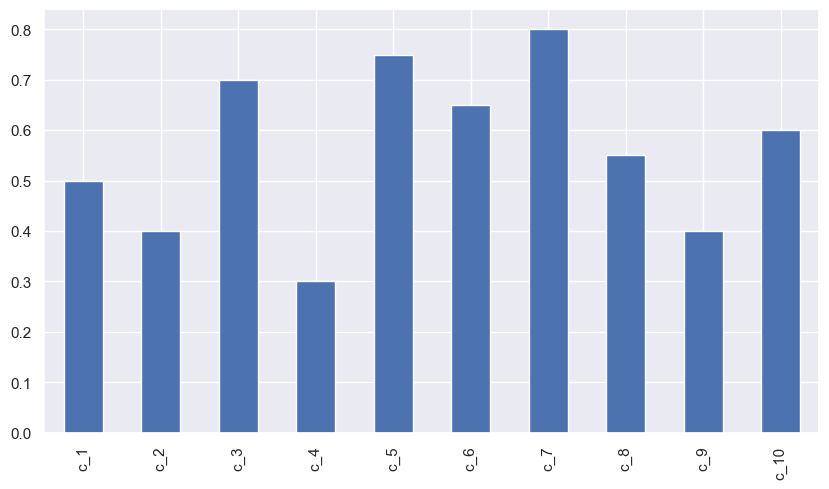

In [22]:
NUMBER_OF_FLIPS = 100

# Probability of getting heads:
COIN_DISTRIBUTIONS = {
    'c_1': .5,  # Fair coin
    'c_2': .4,
    'c_3': .7,
    'c_4': .3,
    'c_5': .75,
    'c_6': .65,
    'c_7': .8,
    'c_8': .55,
    'c_9': .40,
    'c_10': .60,
}

coin_distributions = pd.Series(COIN_DISTRIBUTIONS)
coin_distributions.plot(kind='bar');

In [23]:
DEFAULT_SIMULATION_COUNT = 1_000

# Strat 1: Random Guess - Blindfold Approach

Pick randomly between all 10 coins for all 100 flips.

The general testing procedures is:
1. Define decision-making function.
2. Simulate a bunch of iterations of the game where you use that decision-making function to choose the coin you're going to flip.
3. Analyze the results of all of the games to determine some sort of expected value and distribution of that expected value.

In [24]:
def choose_blindly(coin_distributions:pd.Series) -> str:
    '''Random, equally-weighted sample from the coin distributions.'''
    return rng.choice(coin_distributions.index)

DEFAULT_SIMULATION_COUNT = 1_000
blind_results_df = pd.DataFrame(index=range(NUMBER_OF_FLIPS),columns=range(DEFAULT_SIMULATION_COUNT))

for sim in range(DEFAULT_SIMULATION_COUNT):
    sim_results = []

    for flip in range(NUMBER_OF_FLIPS):
        chosen_coin = choose_blindly(coin_distributions)
        flip_result = rng.binomial(1, coin_distributions[chosen_coin])
        sim_results.append(flip_result)
    blind_results_df[sim] = sim_results
    
blind_results_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,1,0,1,0,0,1,0,0,0,...,1,1,1,0,0,1,0,1,1,1
1,0,1,0,1,1,1,1,1,0,1,...,1,0,1,1,1,1,0,1,0,0
2,1,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,1,1,0,1
3,0,1,0,1,0,1,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,1,1,1,0,1,1,1,1,0,...,1,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,1,1,1,1,0,0,0,1,...,0,1,0,0,1,1,1,0,1,0
96,1,1,0,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,1,0,1
97,1,0,1,1,1,0,1,0,1,0,...,0,0,0,1,1,1,1,0,0,1
98,1,0,0,1,1,1,0,1,1,0,...,0,1,1,0,0,0,0,1,1,1


## Analyze Results

Expected Winnings: 56.43
Standard Deviation: 4.81
95% CI: (48.00, 64.00)
Min: 38
Max: 71


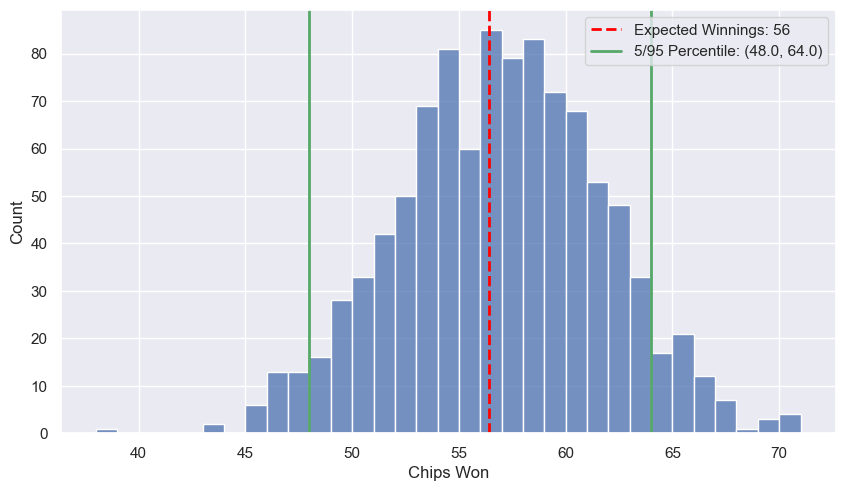

In [25]:
class StratAnalyzer:
    def __init__(self, game_results_df:pd.DataFrame) -> None:
        self.game_results_df = game_results_df

        self.chips_won = game_results_df.sum()
        self.expected_winnings = self.chips_won.mean()
        self.standard_deviation = self.chips_won.std()
        self.percentile_5 = self.chips_won.quantile(.05)
        self.percentile_95 = self.chips_won.quantile(.95)
    
    def plot_distribution(self,bins=None) -> None:
        fig, ax = plt.subplots()
        if bins is not None:
            sns.histplot(self.chips_won, ax=ax,bins=bins,binwidth=1)
        else:
            sns.histplot(self.chips_won, ax=ax,binwidth=1)
        ax.axvline(self.expected_winnings, color='red', linestyle='--', label=f'Expected Winnings: {round(self.expected_winnings,0):.0f}',lw=2)
        ax.axvline(self.percentile_5, color='g',label=f'5/95 Percentile: ({round(self.percentile_5,0)}, {round(self.percentile_95,0)})',lw=2)
        ax.axvline(self.percentile_95,color='g',lw=2)        
        ax.set_xlabel('Chips Won')
        ax.legend()

    def print_summary(self) -> None:
        print(f'Expected Winnings: {self.expected_winnings:.2f}')
        print(f'Standard Deviation: {self.standard_deviation:.2f}')
        print(f'95% CI: ({self.percentile_5:.2f}, {self.percentile_95:.2f})')
        print(f'Min: {self.chips_won.min()}')
        print(f'Max: {self.chips_won.max()}')

blind_strat = StratAnalyzer(blind_results_df)
blind_strat.plot_distribution()
blind_strat.print_summary()

Result makes sense because it's the mean of all the coin's distributions

In [46]:
sum(COIN_DISTRIBUTIONS.values()) / len(COIN_DISTRIBUTIONS)

0.5650000000000001

# Strat Analyze: All Equal-Weighted Coin

In [26]:
def choose_fair_coin(coin_distributions:pd.Series) -> str:
    '''Choose the fair coin.'''
    return 'c_1'


def run_simulations(choose_coin_func:callable, coin_distributions:pd.Series,simulation_count:int=DEFAULT_SIMULATION_COUNT) -> pd.DataFrame:

    # game_results_df = pd.DataFrame(index=range(NUMBER_OF_FLIPS),columns=range(simulation_count))
    game_results = np.zeros((NUMBER_OF_FLIPS, simulation_count))

    for sim in range(simulation_count):
        for flip in range(NUMBER_OF_FLIPS):
            chosen_coin = choose_coin_func(coin_distributions)
            flip_result = rng.binomial(1, coin_distributions[chosen_coin])
            game_results[flip,sim] = flip_result
    game_results_df = pd.DataFrame(game_results)
    return game_results_df


# game_results_df = run_simulations(choose_fair_coin, coin_distributions)
game_results_df = run_simulations(choose_fair_coin, coin_distributions, simulation_count=10_000)
fair_coin_strat = StratAnalyzer(game_results_df)
fair_coin_strat.print_summary()

Expected Winnings: 50.02
Standard Deviation: 4.99
95% CI: (42.00, 58.00)
Min: 30.0
Max: 68.0


In [27]:
# fair_coin_strat.chips_won.value_counts().plot(kind='bar')
# fair_coin_strat.chips_won.value_counts()

Expected Winnings: 50.02
Standard Deviation: 4.99
95% CI: (42.00, 58.00)
Min: 30.0
Max: 68.0


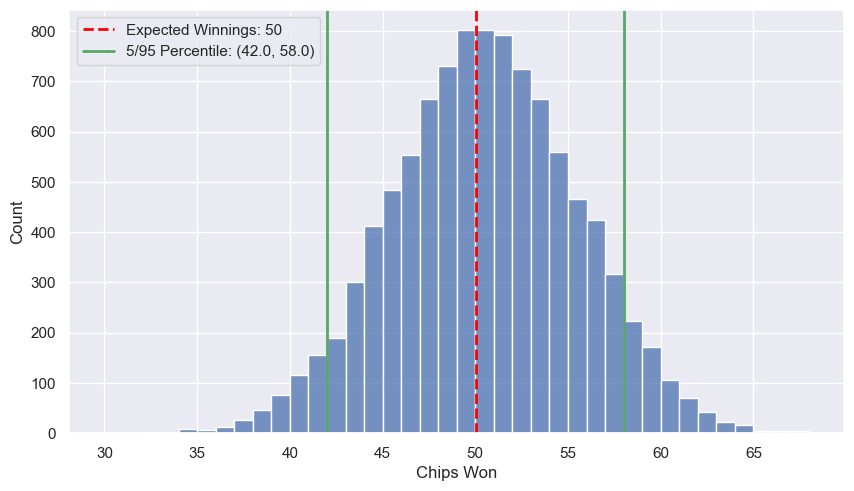

In [28]:
fair_coin_strat.plot_distribution()
fair_coin_strat.print_summary()

# Strat: Pick Random & Commit

In [29]:
# random_commit_results_df

simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 100_000
random_commit_results_df = np.zeros((NUMBER_OF_FLIPS, simulation_count))
for sim in range(simulation_count):
    # Choose the coin we want to commit to
    chosen_coin = choose_blindly(coin_distributions)
    # Simulate 100 flips of that coin.
    simulated_flips = rng.binomial(1, coin_distributions[chosen_coin],NUMBER_OF_FLIPS)
    random_commit_results_df[:,sim] = simulated_flips

random_commit_results_df = pd.DataFrame(random_commit_results_df)
random_commit_strat = StratAnalyzer(random_commit_results_df)
random_commit_strat.print_summary()

Expected Winnings: 56.44
Standard Deviation: 16.35
95% CI: (30.00, 81.00)
Min: 15.0
Max: 93.0


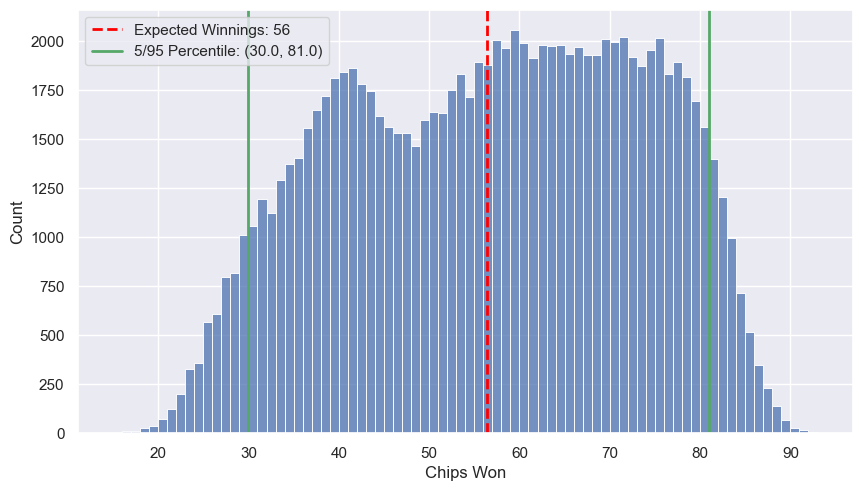

In [30]:
random_commit_strat.plot_distribution()

# Strats: Search & Exploit

## SE1: Seach & Big Commit

In [31]:
def get_max_prob_coin_random(estimated_coin_prob:dict) -> str:
    '''Return the maximum probability coin. If multiple coins have the same probability, choose randomly.'''
    max_prob = max(estimated_coin_prob.values())
    max_prob_coins = [coin for coin, prob in estimated_coin_prob.items() if prob == max_prob]
    random_coin = rng.choice(max_prob_coins)
    return random_coin

In [32]:
# random_commit_results_df
simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 10_000
SEARCH_FLIPS = 5 # Budget around half my flips to data collection
se1_results_df = np.zeros((NUMBER_OF_FLIPS, simulation_count))
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin
for sim in range(simulation_count):
    

    estimated_coin_probs = {'c_1':.5} # This will store our estimates of the probability for each coin
    for i in range(len(search_coins)):
        # Simulate x flips of that coin.
        actual_prob = search_coins.iloc[i]
        coin_label = search_coins.index[i]
        flip_counter = rng.binomial(1, actual_prob, SEARCH_FLIPS)
        estimated_coin_probs[coin_label] = flip_counter.mean()

        # Store the results of these flips in the results df
        se1_results_df[(i)*SEARCH_FLIPS:(i+1)*SEARCH_FLIPS,sim] = flip_counter
    
    # Pick the coin with the highest estimated probability, including the fair coin
    chosen_coin = get_max_prob_coin_random(estimated_coin_probs)
    # Simulate the rest of the flips with that coin
    flips_left = NUMBER_OF_FLIPS - len(search_coins)*SEARCH_FLIPS
    simulated_flips = rng.binomial(1, coin_distributions[chosen_coin],flips_left)
    se1_results_df[len(search_coins)*SEARCH_FLIPS:,sim] = simulated_flips


se1_results_df = pd.DataFrame(se1_results_df)
se1_strat = StratAnalyzer(se1_results_df)
se1_strat.print_summary()

Expected Winnings: 64.89
Standard Deviation: 6.80
95% CI: (52.00, 75.00)
Min: 35.0
Max: 86.0


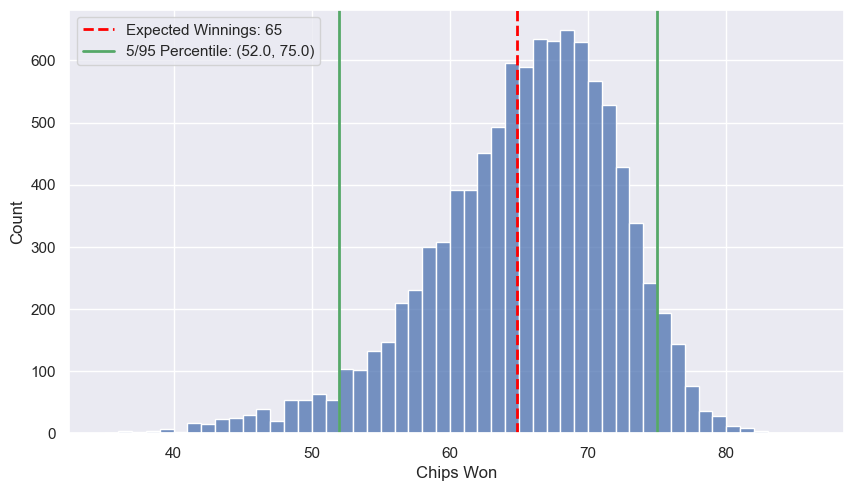

In [33]:
se1_strat.plot_distribution()

## SE2: Continual Prob Eval

In [34]:
def create_data_container(coin_distributions:pd.Series) -> dict:
    data = {'c_1':{'prob':.5,'flip_count':0,'num_heads':0}} 
    for coin in coin_distributions.index[1:]:
        data[coin] = {'prob':np.NaN,'flip_count':0,'num_heads':0}
    return data

# create_data_container(coin_distributions)

Expected Winnings: 66.44
Standard Deviation: 5.12
95% CI: (58.00, 75.00)
Min: 46.0
Max: 83.0


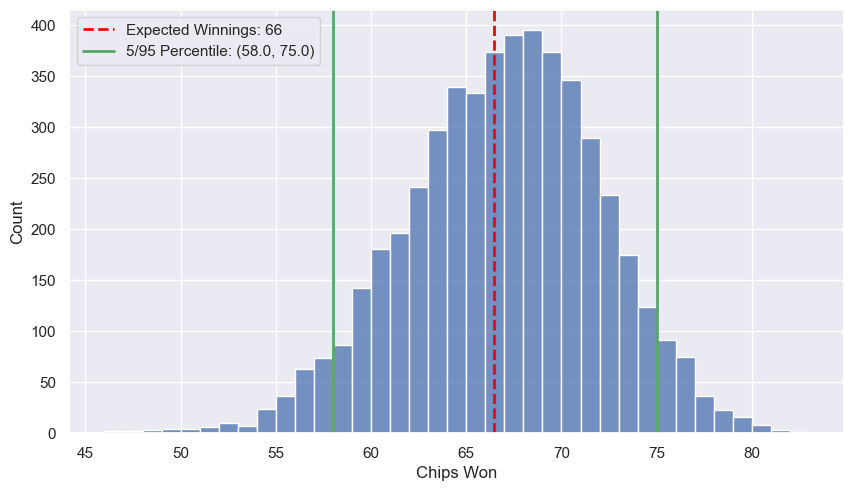

In [47]:
# random_commit_results_df
simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 5000
SEARCH_FLIPS = 5 # Budget around half my flips to data collection
se2_results_df = np.zeros((NUMBER_OF_FLIPS, simulation_count))
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin
for sim in range(simulation_count):
    data = create_data_container(coin_distributions)

    for i in range(len(search_coins)):
        actual_prob = search_coins.iloc[i]
        coin_label = search_coins.index[i]
        flip_counter = rng.binomial(1, actual_prob, SEARCH_FLIPS)
        # Store the data in the data container
        data[coin_label]['flip_count'] += SEARCH_FLIPS
        data[coin_label]['num_heads'] += flip_counter.sum()
        data[coin_label]['prob'] = flip_counter.mean()

        # Store the results of these flips in the results df
        se2_results_df[(i)*SEARCH_FLIPS:(i+1)*SEARCH_FLIPS,sim] = flip_counter
    
    # Loop through the rest of my flips. Each time, flip the highest estimated probablility coin. After flipping, update the estimated probability of that coin.
    flips_left = NUMBER_OF_FLIPS - len(search_coins)*SEARCH_FLIPS
    for flip in range(len(search_coins)*SEARCH_FLIPS,NUMBER_OF_FLIPS):
        estimated_coin_probs = {coin:data[coin]['prob'] for coin in data}
        chosen_coin = get_max_prob_coin_random(estimated_coin_probs)
        simulated_flip = rng.binomial(1, coin_distributions[chosen_coin])
        # Update the data container
        data[chosen_coin]['num_heads'] += simulated_flip
        data[chosen_coin]['flip_count'] += 1
        # Update the estimated probability of the chosen coin, unless it is the fair coin
        if chosen_coin != 'c_1':
            data[chosen_coin]['prob'] = data[chosen_coin]['num_heads']/data[chosen_coin]['flip_count']
        se2_results_df[flip,sim] = simulated_flip


se2_results_df = pd.DataFrame(se2_results_df)
se2_strat = StratAnalyzer(se2_results_df)
se2_strat.print_summary()
se2_strat.plot_distribution()

## SE3: Optimal Coin Budget?
Find the "best" coin budget to use during the search process. Best is defined as the budget that provides the highest expected value.

In [36]:
SIMS_PER_BUDGET = 4000
budgets = range(1,11) # Budgets from 1 to 10
overall_results = {}
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin

for budget in budgets:
    results_df = np.zeros((NUMBER_OF_FLIPS, SIMS_PER_BUDGET))
    for sim in range(SIMS_PER_BUDGET):
        data = create_data_container(coin_distributions)

        for i in range(len(search_coins)):
            actual_prob = search_coins.iloc[i]
            coin_label = search_coins.index[i]
            flip_counter = rng.binomial(1, actual_prob, budget)
            # Store the data in the data container
            data[coin_label]['flip_count'] += budget
            data[coin_label]['num_heads'] += flip_counter.sum()
            data[coin_label]['prob'] = flip_counter.mean()

            # Store the results of these flips in the results df
            results_df[(i)*budget:(i+1)*budget,sim] = flip_counter

        # Loop through the rest of my flips. Each time, flip the highest estimated probablility coin. After flipping, update the estimated probability of that coin.
        flips_left = NUMBER_OF_FLIPS - len(search_coins)*budget
        for flip in range(len(search_coins)*budget,NUMBER_OF_FLIPS):
            estimated_coin_probs = {coin:data[coin]['prob'] for coin in data}
            chosen_coin = get_max_prob_coin_random(estimated_coin_probs)
            simulated_flip = rng.binomial(1, coin_distributions[chosen_coin])
            # Update the data container
            data[chosen_coin]['num_heads'] += simulated_flip
            data[chosen_coin]['flip_count'] += 1
            # Update the estimated probability of the chosen coin, unless it is the fair coin
            if chosen_coin != 'c_1':
                data[chosen_coin]['prob'] = data[chosen_coin]['num_heads']/data[chosen_coin]['flip_count']
            results_df[flip,sim] = simulated_flip

    results_df = pd.DataFrame(results_df)
    strat = StratAnalyzer(results_df)
    overall_results[budget] = strat


In [37]:
df_results = pd.DataFrame()
df_results['expected_winnings'] = [overall_results[budget].expected_winnings for budget in overall_results]
df_results['standard_deviation'] = [overall_results[budget].standard_deviation for budget in overall_results]
df_results['percentile_2_5'] = [overall_results[budget].percentile_5 for budget in overall_results]
df_results['percentile_97_5'] = [overall_results[budget].percentile_95 for budget in overall_results]
df_results['min'] = [overall_results[budget].chips_won.min() for budget in overall_results]
df_results['max'] = [overall_results[budget].chips_won.max() for budget in overall_results]
df_results['sharpe'] = df_results['expected_winnings']/df_results['standard_deviation']
df_results.index = budgets
df_results

,expected_winnings,standard_deviation,percentile_2_5,percentile_97_5,min,max,sharpe
1,70.92975,7.075933,58.0,81.0,34.0,87.0,10.024084
2,70.30175,6.368268,59.0,79.0,38.0,88.0,11.039383
3,69.25300,5.809727,59.0,78.0,40.0,85.0,11.920181
4,67.85475,5.533878,59.0,77.0,40.0,83.0,12.261699
5,66.37300,5.249787,57.0,75.0,39.0,84.0,12.642990
6,64.94200,4.982955,56.0,73.0,42.0,81.0,13.032828
7,63.54300,4.869043,55.0,71.0,46.0,80.0,13.050409
8,62.16000,4.704831,54.0,70.0,46.0,77.0,13.211952
9,60.49425,4.710840,53.0,68.0,36.0,78.0,12.841499
10,58.93100,4.584048,51.0,67.0,42.0,74.0,12.855669


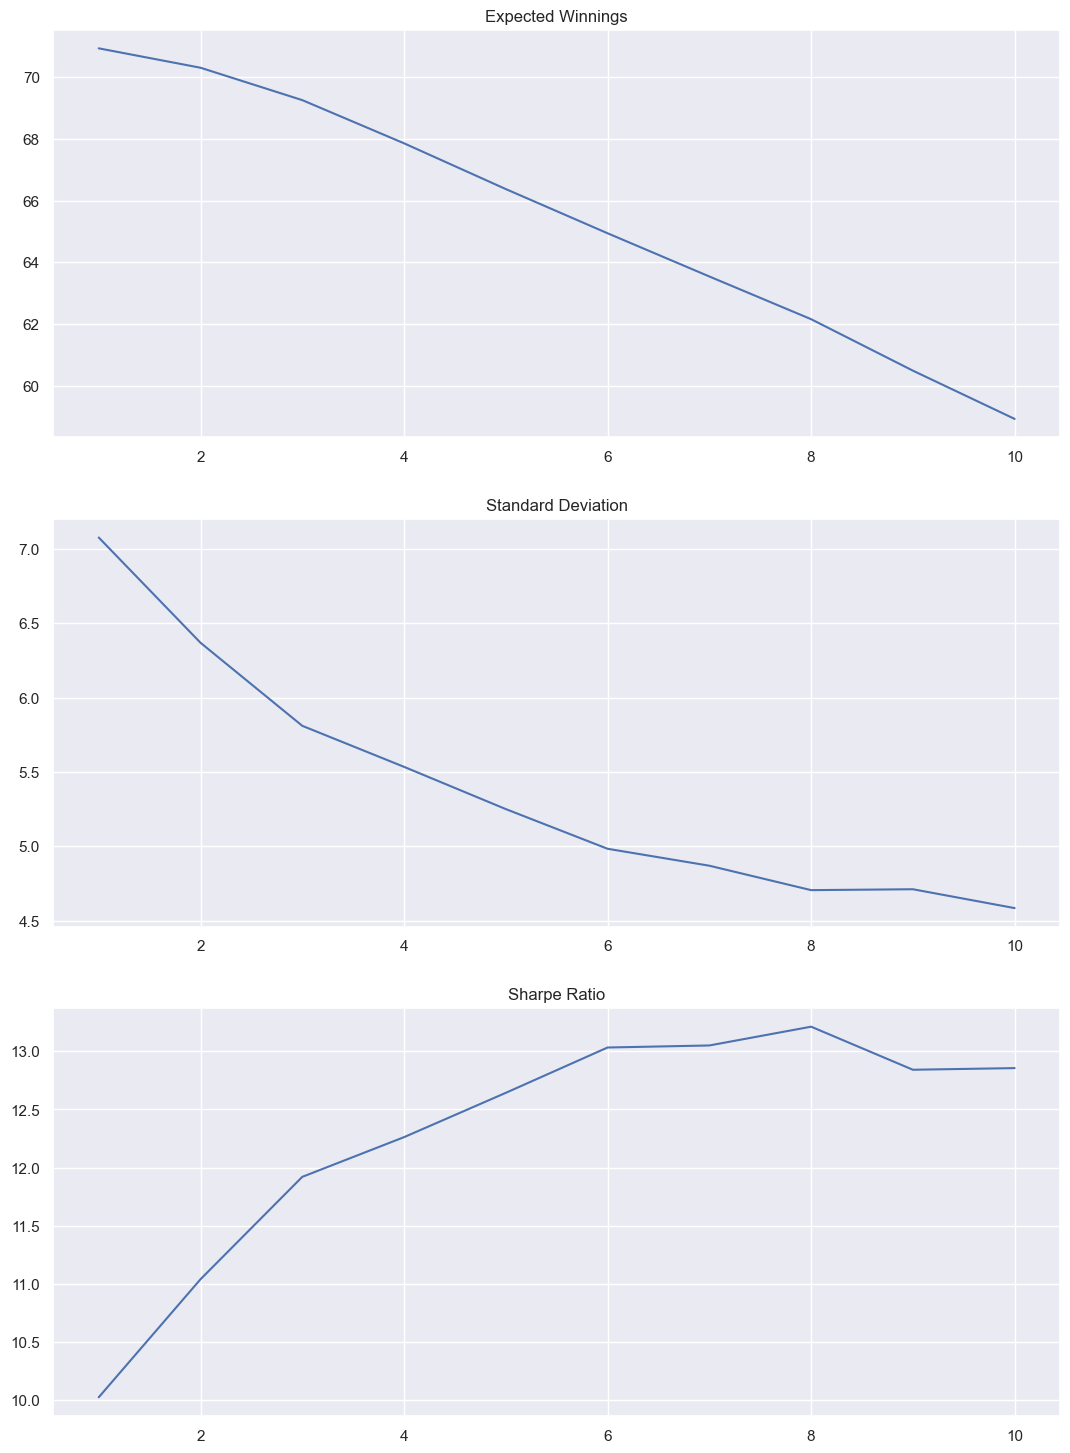

In [38]:
# Same plot as above, but each on their own plot
fig, ax = plt.subplots(3,1,figsize=(13,18))
df_results['expected_winnings'].plot(ax=ax[0], label='Expected Winnings')
df_results['standard_deviation'].plot(ax=ax[1], label='Standard Deviation')
df_results['sharpe'].plot(ax=ax[2], label='Sharpe Ratio')
ax[0].title.set_text('Expected Winnings')
ax[1].title.set_text('Standard Deviation')
ax[2].title.set_text('Sharpe Ratio');

8
Expected Winnings: 62.16
Standard Deviation: 4.70
95% CI: (54.00, 70.00)
Min: 46.0
Max: 77.0


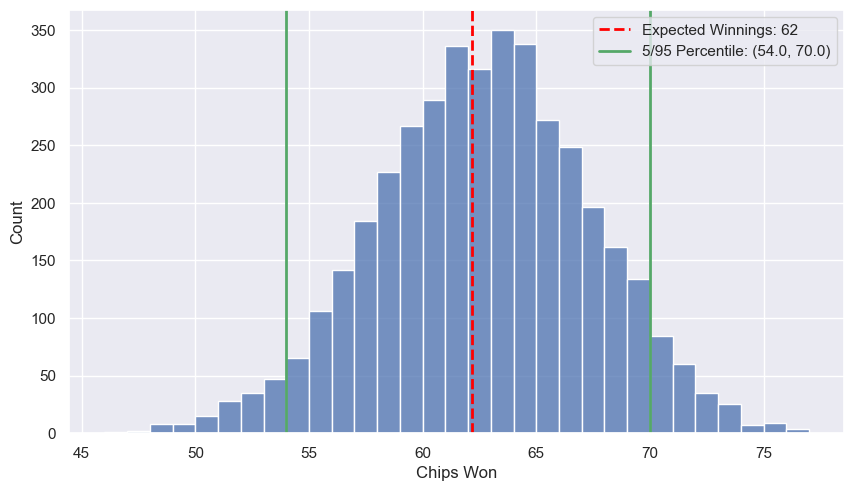

In [39]:
best_strat = max(overall_results, key=lambda x: overall_results[x].expected_winnings)
best_strat = max(overall_results, key=lambda x: overall_results[x].expected_winnings / overall_results[x].standard_deviation)
print(best_strat)
overall_results[best_strat].print_summary()
overall_results[best_strat].plot_distribution()

## SE4: Sam's Method
Flip each coin, until we get tails. Then exploit: always picking highest estimated prob.

Expected Winnings: 69.07
Standard Deviation: 5.93
95% CI: (59.00, 78.00)
Min: 45.0
Max: 83.0


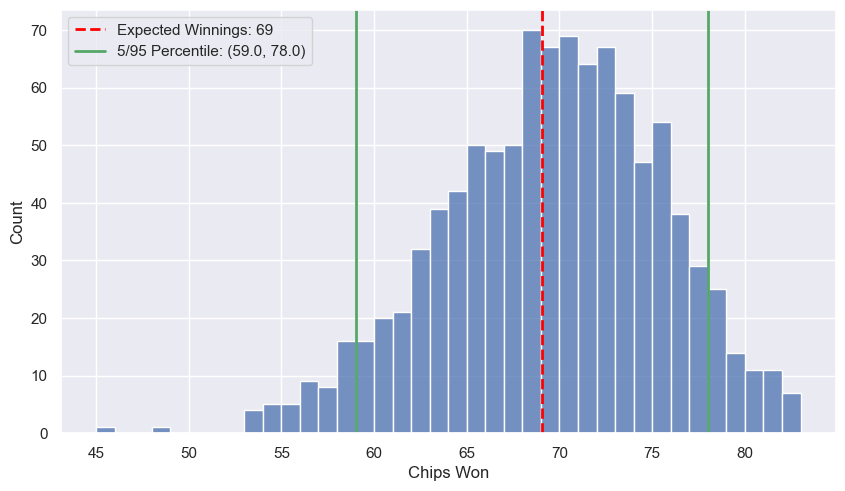

In [48]:
simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 1_000
# Create the results df, but make the default option nulls this time
results_df = np.zeros((NUMBER_OF_FLIPS, simulation_count)) *  np.nan
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin
MIN_FLIPS = 3



for sim in range(simulation_count):
    data = create_data_container(coin_distributions)
    flip_counter = 0
    # Continue "Exploring Coins" until we have hit tails and have hit our min flips for that coin
    not_explored = list(search_coins.index)
    while len(not_explored) > 0:

        # Randomly choose a coin to explore
        chosen_coin = rng.choice(not_explored)
        not_explored.remove(chosen_coin)
        # Keep flipping until we hit tails or we have hit our min flips for that coin
        while (data[chosen_coin]['num_heads'] == data[chosen_coin]['flip_count']) or  (data[chosen_coin]['flip_count'] < MIN_FLIPS) :
            flip = rng.binomial(1, coin_distributions[chosen_coin])
            data[chosen_coin]['flip_count'] += 1
            data[chosen_coin]['num_heads'] += flip
            results_df[flip_counter,sim] = flip
            flip_counter += 1
            # if The flips ever exceed the number of flips, break out of all loops
            if flip_counter >= NUMBER_OF_FLIPS:
                print('Breaking!!')
                print(flip_counter,not_explored)
        
    # Now that we have explored all coins in a smart way, we can flip the one with highest probability
    # Update the probablilities of each coin
    for coin in data:
        if coin != 'c_1':
            data[coin]['prob'] = data[coin]['num_heads']/data[coin]['flip_count']


    flips_left = NUMBER_OF_FLIPS - flip_counter
    for i in range(flip_counter,NUMBER_OF_FLIPS):
        estimated_coin_probs = {coin:data[coin]['prob'] for coin in data if coin != 'c_1'}
        chosen_coin = get_max_prob_coin_random(estimated_coin_probs)
        flip = rng.binomial(1, coin_distributions[chosen_coin])
        results_df[i,sim] = flip
        data[chosen_coin]['flip_count'] += 1
        data[chosen_coin]['num_heads'] += flip
        if chosen_coin != 'c_1':
            data[chosen_coin]['prob'] = data[chosen_coin]['num_heads']/data[chosen_coin]['flip_count']
            

results_df = pd.DataFrame(results_df)
se4_strat = StratAnalyzer(results_df)
se4_strat.print_summary()
se4_strat.plot_distribution()


In [41]:
estimated_coin_probs
data

{'c_1': {'prob': 0.5, 'flip_count': 0, 'num_heads': 0},
 'c_2': {'prob': 0.0, 'flip_count': 1, 'num_heads': 0},
 'c_3': {'prob': 0.5, 'flip_count': 2, 'num_heads': 1},
 'c_4': {'prob': 0.0, 'flip_count': 1, 'num_heads': 0},
 'c_5': {'prob': 0.6666666666666666, 'flip_count': 3, 'num_heads': 2},
 'c_6': {'prob': 0.5, 'flip_count': 2, 'num_heads': 1},
 'c_7': {'prob': 0.8571428571428571, 'flip_count': 84, 'num_heads': 72},
 'c_8': {'prob': 0.75, 'flip_count': 4, 'num_heads': 3},
 'c_9': {'prob': 0.0, 'flip_count': 1, 'num_heads': 0},
 'c_10': {'prob': 0.5, 'flip_count': 2, 'num_heads': 1}}